<a href="https://colab.research.google.com/github/benbaz-2/comp551/blob/Aziz/a2_aziz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

## Constants

In [36]:
# Random seed
np.random.seed(42)

# Sample size
n = 100

# Range
range_min = 0
range_max = 20
range_x = np.linspace(range_min, range_max, 100)

# Original function
f = lambda x: np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x)

# Gaussian function
gaussian = lambda x, mu: np.exp(-(x-mu)**2)

# Number of gaussian basis functions
num_gaussian_bases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
nnum_gaussian_bases = len(num_gaussian_bases)

# Train/test set ratio
r = 0.8

# Default number of basis functions in Task 3
b = 70


## Task 1: Linear Regression with Non-Linear Basis Functions

### 1. Data generation

Text(0, 0.5, 'y')

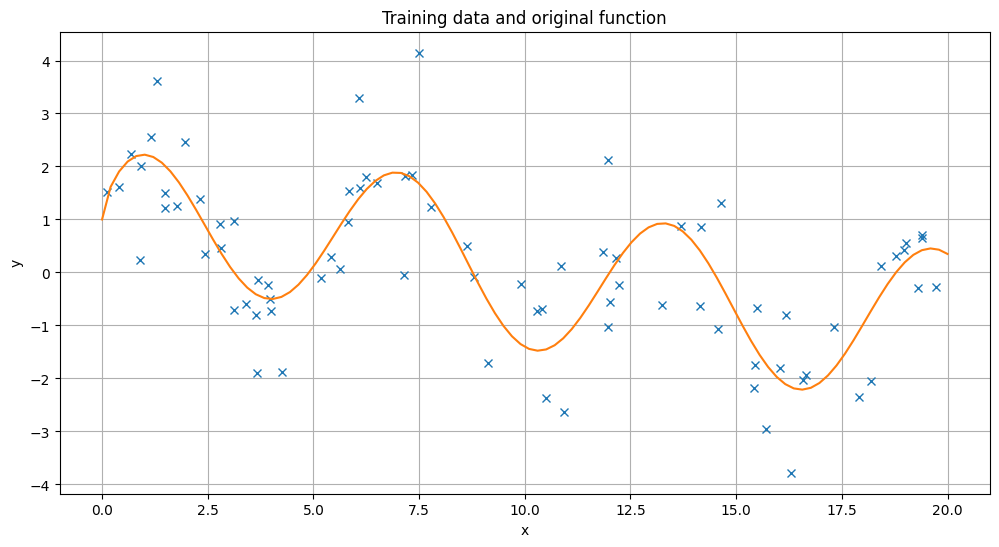

In [26]:
# Generate noisy data from original function
def generate_data(n, train=r):
  train_size = int(n * train)

  # Sample the range uniformly
  x = np.random.uniform(range_min, range_max, n)

  # Sample the error from a normal distribution with mean 0 and variance 1
  e = np.random.normal(0, 1, n)

  x_train = np.sort(x[: train_size])
  x_test = np.sort(x[train_size:])

  y_train = f(x_train) + e[:train_size]
  y_test = f(x_test) + e[train_size:]

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(n)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x_train, y_train, 'x')
plt.plot(range_x, f(range_x))
plt.grid()

plt.title('Training data and original function')
plt.xlabel('x')
plt.ylabel('y')

### 2. Non-linear basis functions

Text(0.5, 0.98, 'gaussian functions')

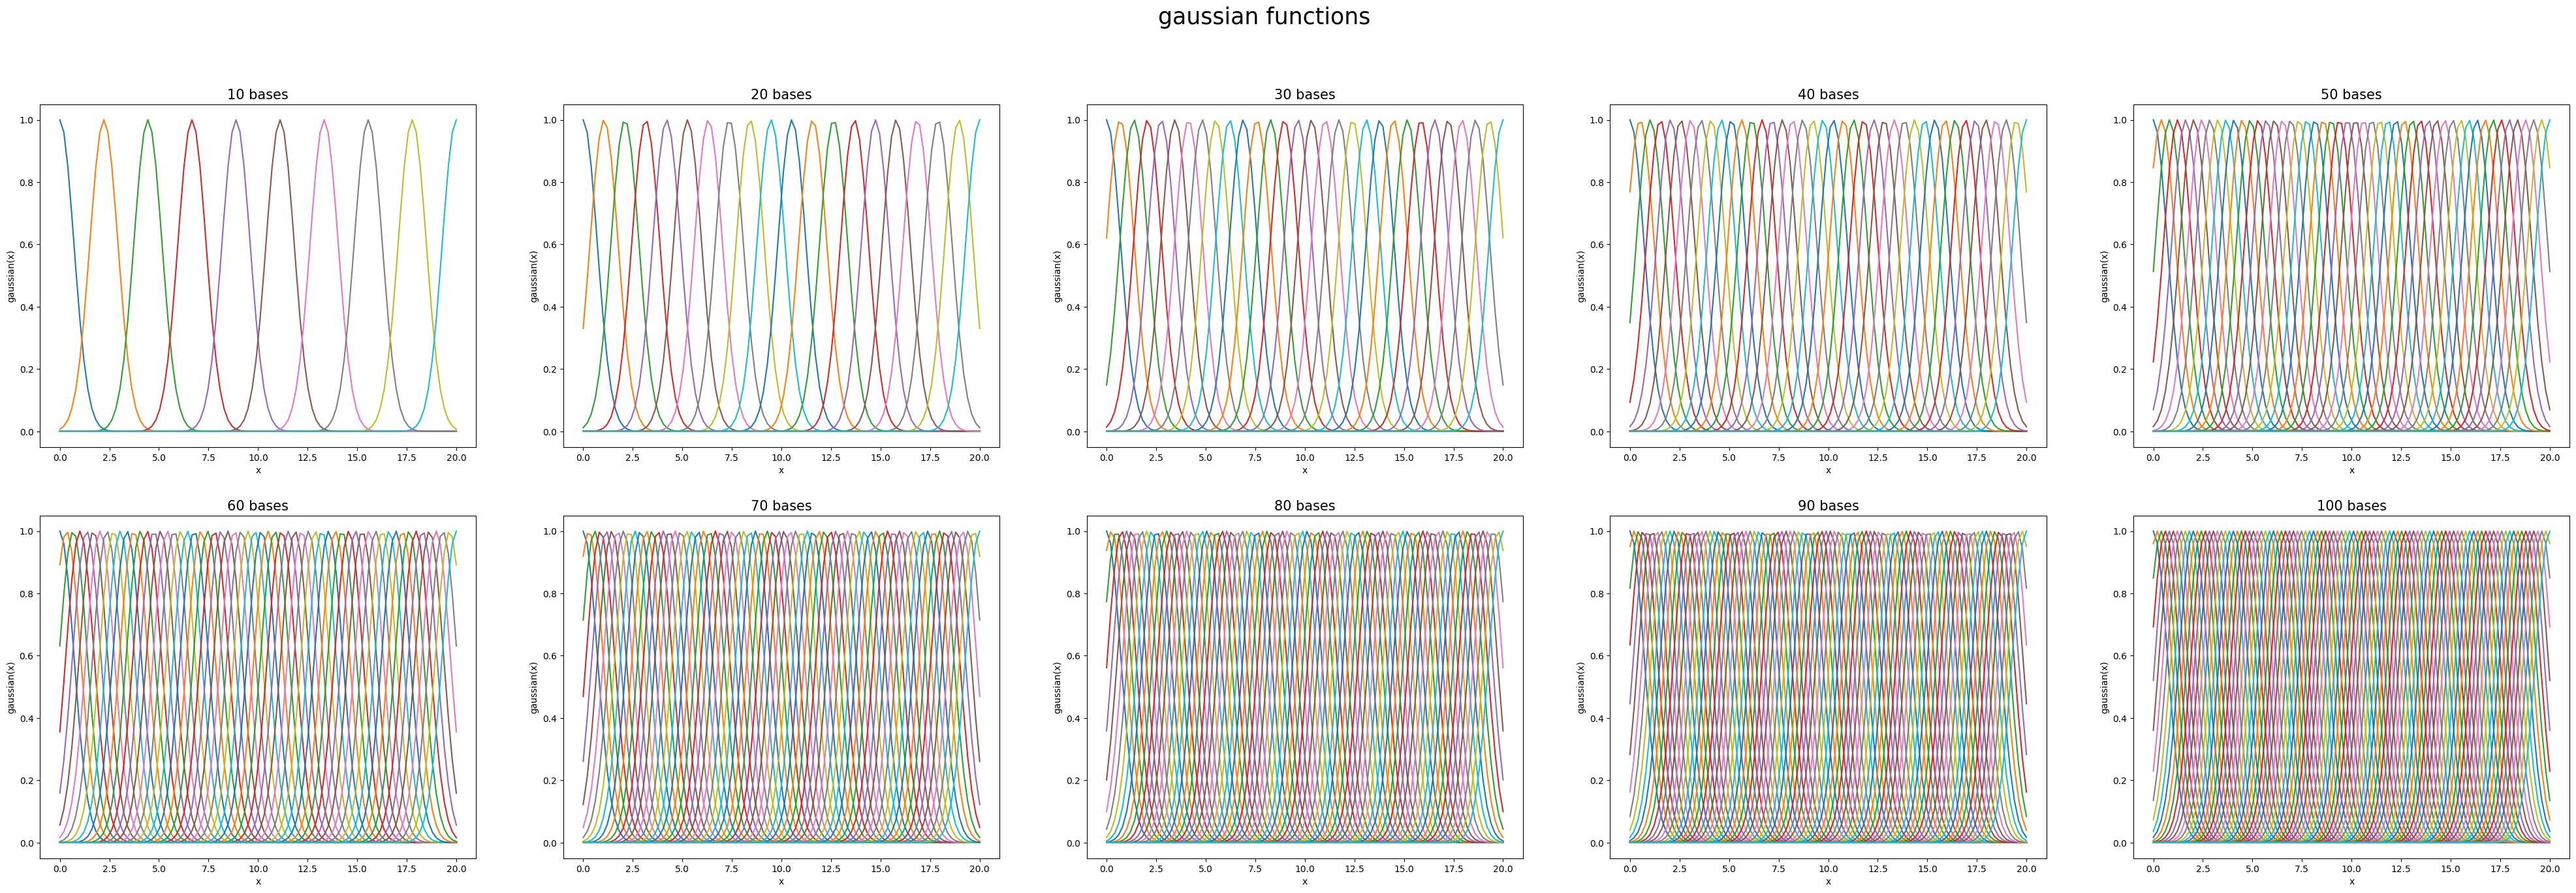

In [31]:
# Generate the figure to plot the non-linear basis functions
fig, ax = plt.subplots(2, 5, figsize=(50, 15))
fig.suptitle('Gaussian functions with different means', fontsize=20)
ax = ax.flatten()                                                     # This makes it easier to iterate over the ax array

# plot the gaussian functions for each number of basis functions
for i, j in  enumerate(num_gaussian_bases[1:]):

  mus = np.linspace(range_min, range_max, j)  # Generate the means mus
  for mu in mus:
      ax[i].plot(range_x, gaussian(range_x, mu))

  ax[i].set_title(f'{j} bases', fontsize=15)
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('gaussian(x)')

fig.suptitle('gaussian functions', fontsize=25)

In [28]:
# Implementation of the gaussian regression model
class GaussianRegression:
  def __init__(self, b, add_bias=True):
    self.add_bias = add_bias
    self.b = b                                        # b is the number of gaussian bases used
    self.w = None

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.zeros((len(x), self.b))
    mus = np.linspace(0, 20, self.b)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                      # Generate the design matrix
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
    return self

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def loss(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error


### 3. Model fitting

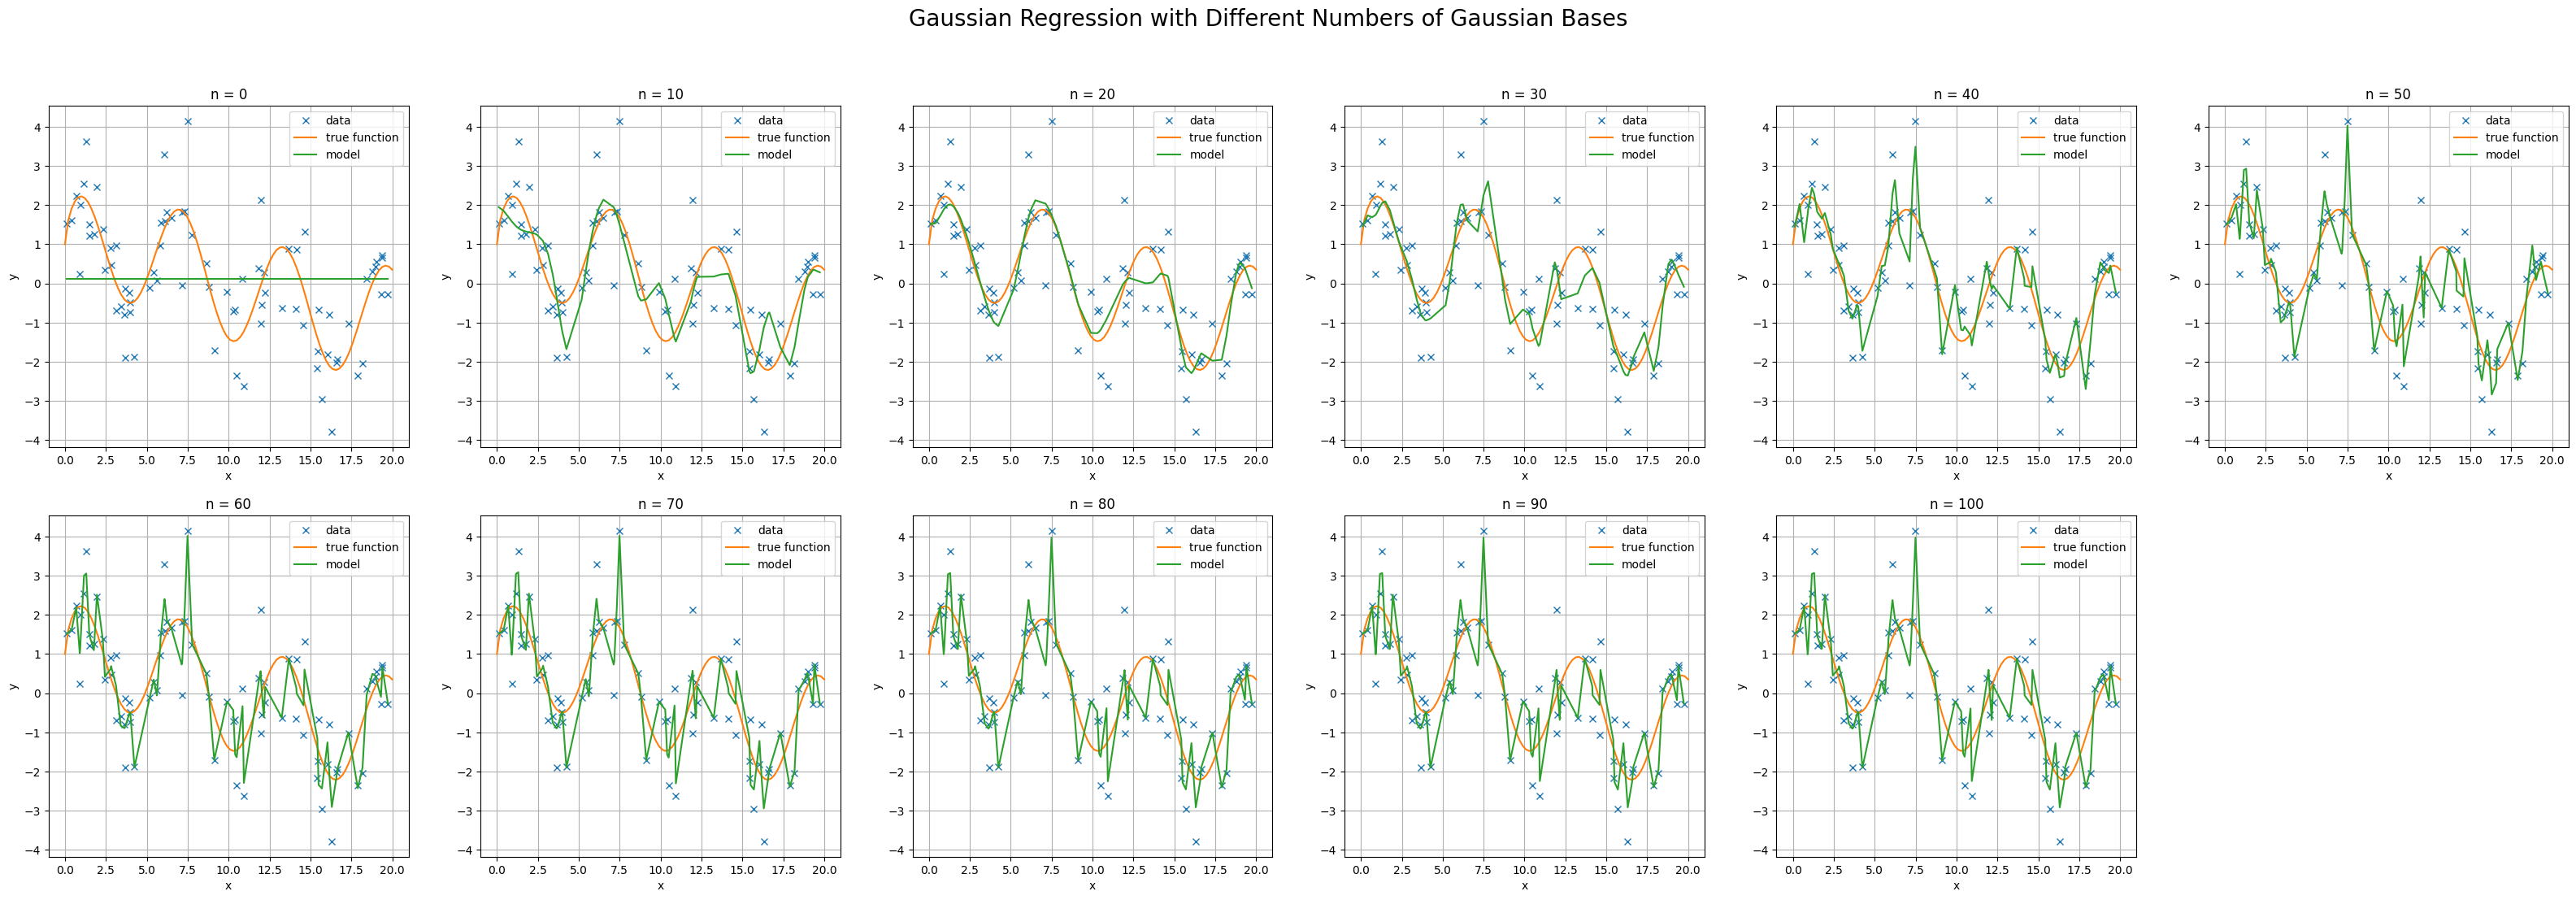

In [29]:
# Create 11 models with different number of gaussian basis functions

def fit_models(x_train, y_train, x_test, y_test):

  models = []
  for n in num_gaussian_bases:
    model = GaussianRegression(n)
    model.fit(x_train, y_train)
    models.append(model)

  return models

models = fit_models(x_train, y_train, x_test, y_test)

# plot the predictions alongside the original function and data
fig, ax = plt.subplots(2, 6, figsize=(40, 12))
fig.suptitle('Gaussian Regression with Different Numbers of Gaussian Bases', fontsize=20)
ax = ax.flatten()

for i, m in enumerate(models):
  p = m.predict(x_train)
  ax[i].set_title(f'n = {num_gaussian_bases[i]}')
  ax[i].set_xlabel('x')
  ax[i].set_ylabel('y')
  ax[i].plot(x_train, y_train, 'x', label='data')
  ax[i].plot(range_x, f(range_x), label='true function')
  ax[i].plot(x_train, p, label='model')
  ax[i].legend()
  ax[i].grid()

ax[-1].set_visible(False)

### 4. Model evaluation

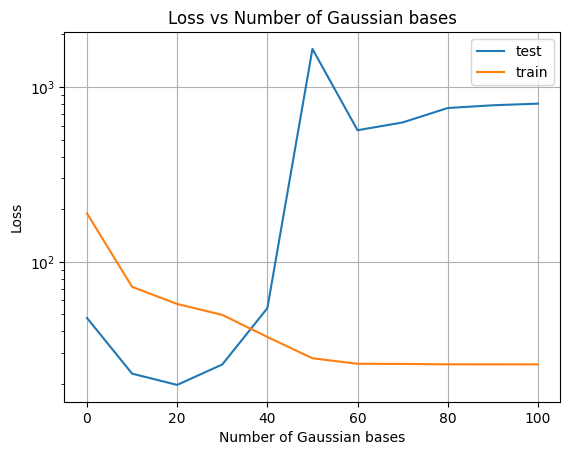

In [30]:
train_losses = []
test_losses = []

for m in models:
  train_losses.append(m.loss(x_train, y_train))
  test_losses.append(m.loss(x_test, y_test))

plt.plot(num_gaussian_bases, test_losses, label='test')
plt.plot(num_gaussian_bases, train_losses, label='train')
plt.legend()
plt.xlabel('Number of Gaussian bases')
plt.ylabel('Loss')
plt.title('Loss vs Number of Gaussian bases')
plt.yscale('log')                                   # Note the performance gets worse very quickly at some point due to overfitting. This is a log scale.
plt.grid()

### 5. Explanation

## Task 2: Bias-variance tradeoff with multiple fits

### 1. Repeating the process

In [33]:
# Fitting 10 models and recording losses on train and test sets and predictions

num_models = 10

models = []
inputs = []
predictions = np.empty((num_models, nnum_gaussian_bases), dtype=object)
train_losses = np.zeros(nnum_gaussian_bases)
test_losses = np.zeros(nnum_gaussian_bases)

for i in range(num_models):
  x_train, y_train, x_test, y_test = generate_data(n)
  inputs.append(x_train)
  models.append(fit_models(x_train, y_train, x_test, y_test))
  for j in range(nnum_gaussian_bases):
    train_losses[j] += models[i][j].loss(x_train, y_train)
    test_losses[j] += models[i][j].loss(x_test, y_test)
    predictions[i, j] = models[i][j].predict(x_train)

train_losses /= num_models
test_losses /= num_models

### 2. Plotting multiple fits

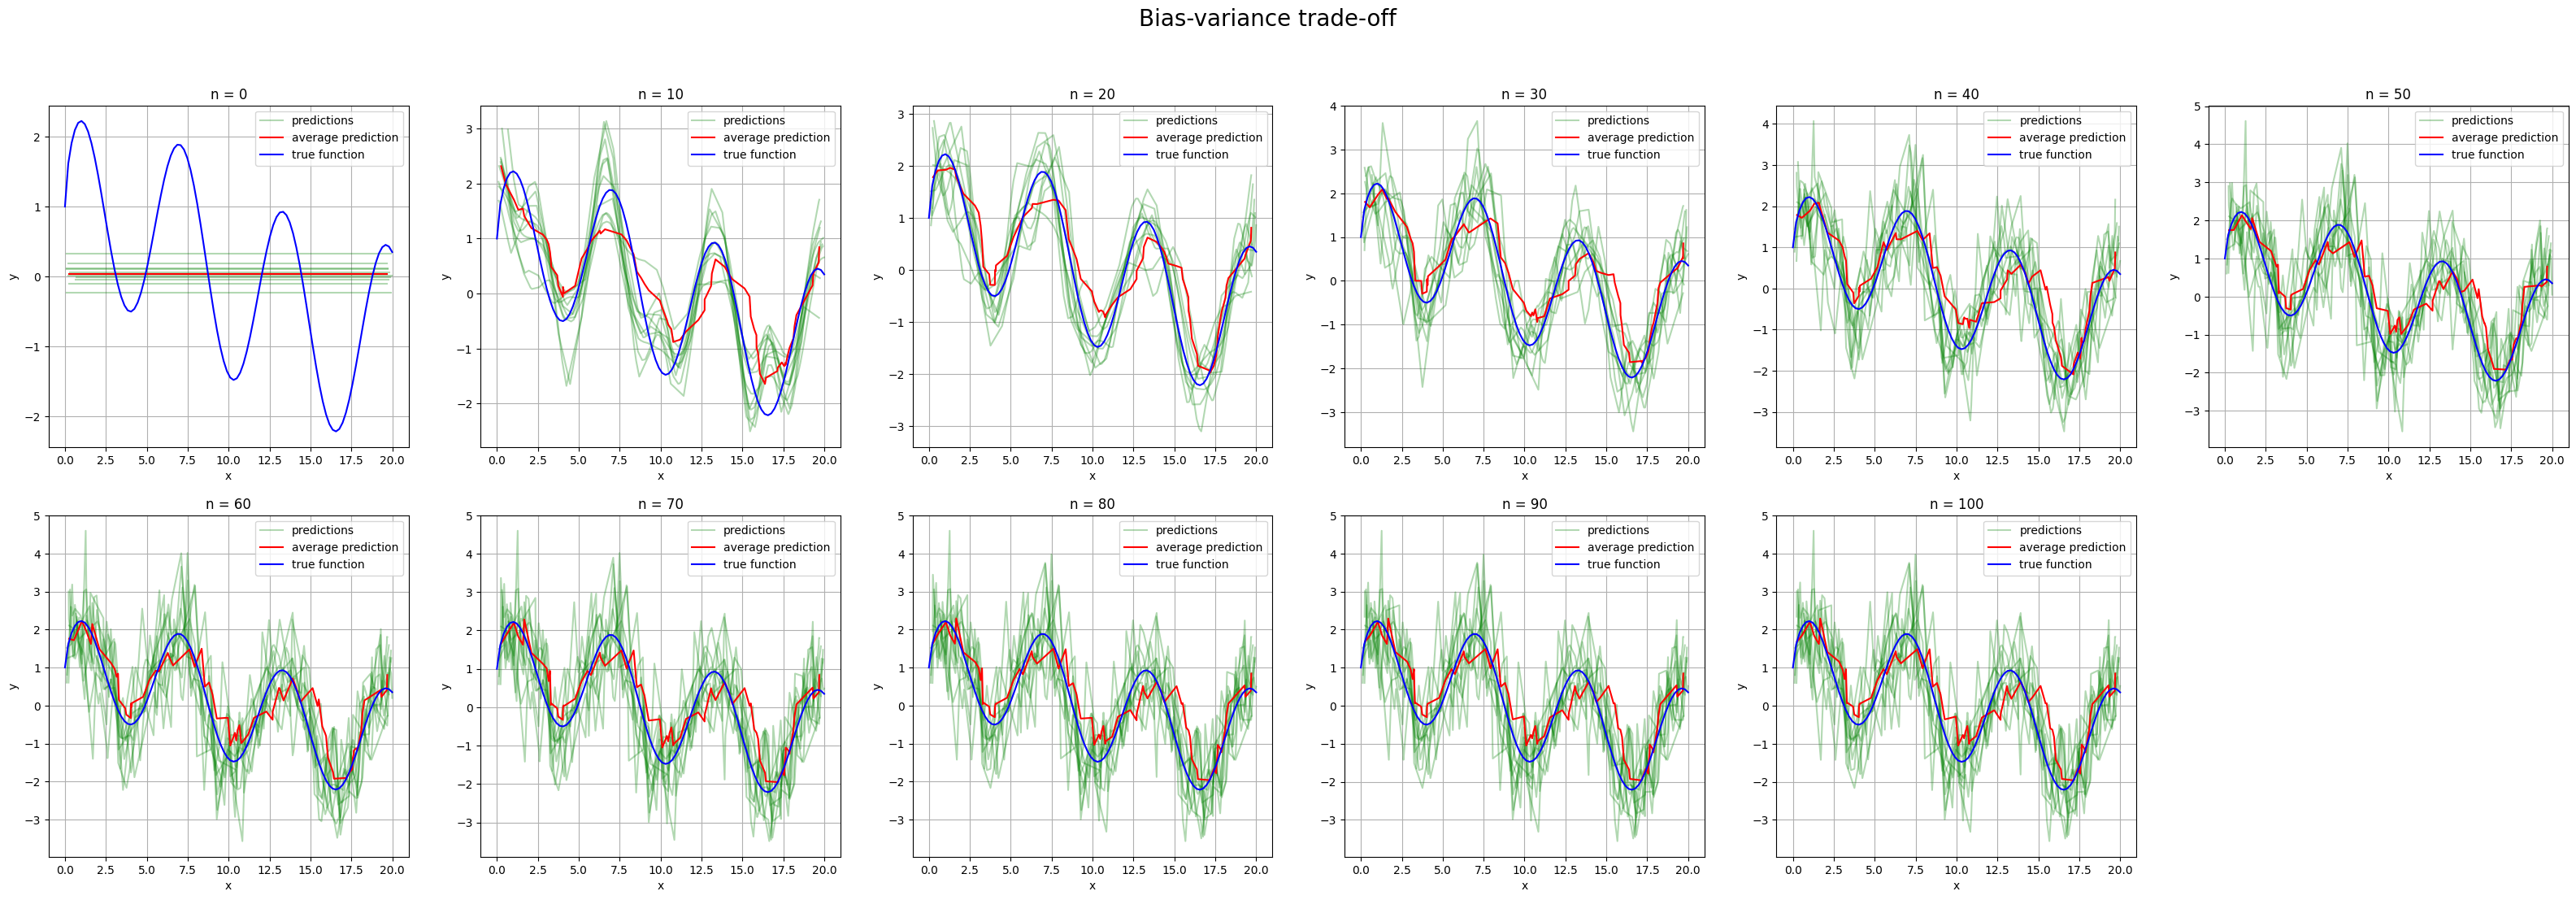

In [34]:
# plotting predictions to see bias variance trade-off

fig, ax = plt.subplots(2, 6, figsize=(40, 12))
fig.suptitle('Bias-variance trade-off', fontsize=20)
ax = ax.flatten()

for j in range(nnum_gaussian_bases):
  average_predictions = np.zeros((len(x_train), 1))
  for i in range(num_models):
    line = ax[j].plot(inputs[i], predictions[i, j], color='green', alpha=0.3, label='predictions' if i == 0 else '')
    average_predictions += predictions[i, j]

  average_predictions /= num_models


  ax[j].plot(x_train, average_predictions, color='red', label='average prediction')
  ax[j].plot(range_x, f(range_x), color='blue', label='true function')
  ax[j].set_title(f'n = {num_gaussian_bases[j]}')
  ax[j].set_xlabel('x')
  ax[j].set_ylabel('y')
  ax[j].grid()
  ax[j].legend()

ax[-1].set_visible(False)


### 3. Plotting training and test error

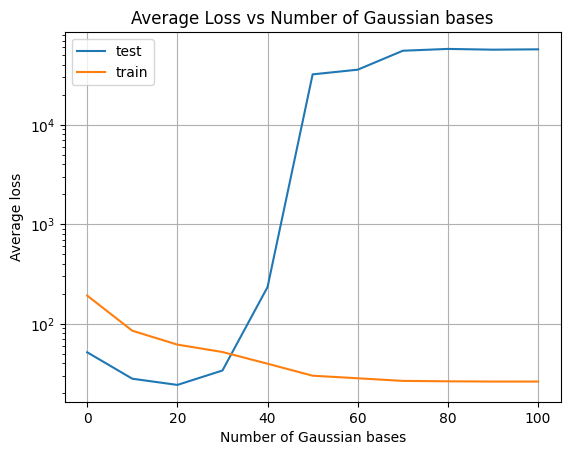

In [35]:
plt.plot(num_gaussian_bases, test_losses, label='test')
plt.plot(num_gaussian_bases, train_losses, label='train')
plt.legend()
plt.xlabel('Number of Gaussian bases')
plt.ylabel('Average loss')
plt.title('Average Loss vs Number of Gaussian bases')
plt.yscale('log')
plt.grid()


### 4. Explaining bias and variance

## Task 3: Regularization with cross-validation

### 1. Add regularization

In [38]:
# Implementation of the gaussian regression model with lasso and ridge
class GaussianRegression:
  def __init__(self, b, add_bias=True, epsilon=5e-2, alpha=1e-3, lambdaa=1e-2, max_iter=1e5, lasso=False, ridge=False):
    self.add_bias = add_bias
    self.b = b                                        # b is the number of gaussian bases used
    self.epsilon = epsilon
    self.alpha = alpha
    self.lambdaa = lambdaa
    self.max_iter = max_iter
    self.w = None
    self.lasso = lasso
    self.ridge = ridge

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.zeros((len(x), self.b))
    mus = np.linspace(0, 20, self.b)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                     # Generate the design matrix

    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))

    if self.lasso:
      self.w = self.lasso_fit(X, y)
      return self

    elif self.ridge:
      I = np.eye(X.shape[1])
      self.w = np.linalg.pinv(X.T @ X + self.lambdaa * I) @ X.T @ y
      return self

    else:
      self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
      return self

  def lasso_fit(self, X, y):
    w = np.zeros((X.shape[1], 1))
    e = np.inf
    i = 0
    while e > self.epsilon and i < self.max_iter:
      N, D = X.shape
      gradient = 1/N * X.T @ (X @ w - y) + self.lambdaa * np.sign(w)
      w = w - self.alpha * gradient
      e = np.linalg.norm(gradient)
      gs.append(e)
      ws.append(np.linalg.norm(w))
      i += 1
    return w

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def loss(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error


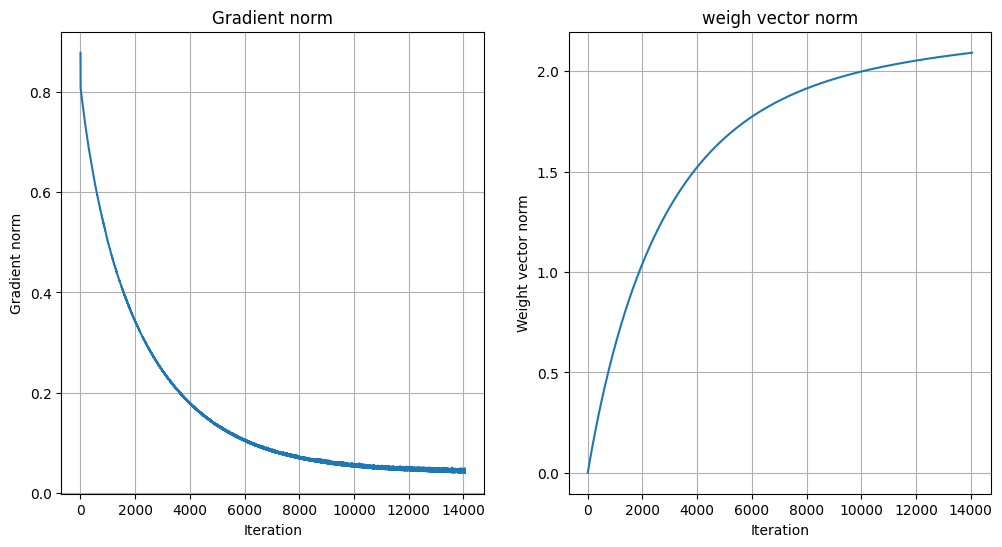

In [39]:
# Plot gradient and weight vector norms to optimize hyperparameters

gs = []   # keep track of gradient norms
ws = []   # keep track of weight norms

lasso = GaussianRegression(b, lasso=True, alpha=0.001, lambdaa=0.01, epsilon=0.04, max_iter=100000)
lasso.fit(x_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(gs)
ax[1].plot(ws)

ax[0].set_title('Gradient norm')
ax[1].set_title('weigh vector norm')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel('Gradient norm')
ax[1].set_ylabel('Weight vector norm')
ax[0].grid()
ax[1].grid()

Text(0.5, 1.0, 'Lasso and Ridge regression')

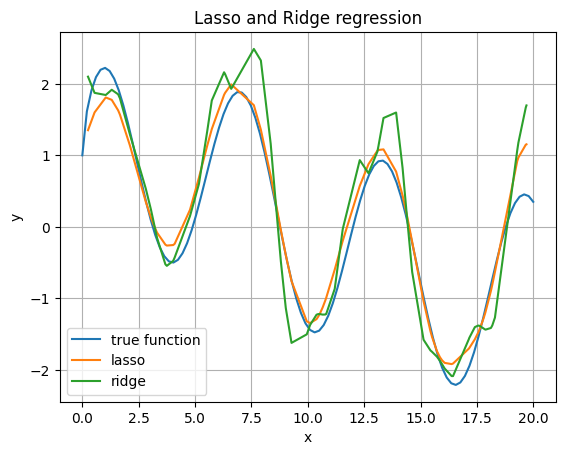

In [40]:
# Plot lasso and ridge model predictions
lasso = GaussianRegression(b, lasso=True)
lasso.fit(x_train, y_train)
ridge = GaussianRegression(b, ridge=True)
ridge.fit(x_train, y_train)

plt.plot(range_x, f(range_x), label='true function')
plt.plot(x_train, lasso.predict(x_train), label='lasso')
plt.plot(x_train, ridge.predict(x_train), label='ridge')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lasso and Ridge regression')